In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c

In [24]:
class convergence_plotter():
    def __init__(self,walkers,num_run,data_dir):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        
    def opener(self):
        f = [x for x in glob.glob(f'{self.data_dir}/*.hdf5')]  
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return None
        
    def perc_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            y,up_perc,lo_perc = [], [], []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            for n in range(inc):
                up = np.percentile(sample[:step*(1+n)],84.1)
                lo = np.percentile(sample[:step*(1+n)],15.9)
                med = np.median(sample[:step*(1+n)])
                up_perc.append(up-med)
                lo_perc.append(med-lo)
                y.append(med)
            
            yerr = np.vstack((up_perc,lo_perc))    
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx+1} percentile plot')
            plt.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
            plt.xlim(-10000,None)
            plt.show()
    
    def hist_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal=len(data)
            
        for sample,idx in zip(data,range(num_gal)):
            length = len(sample)
            inc = length//step
            colors = plt.cm.copper_r(np.linspace(0,1,inc))
            plt.figure(figsize=(12,9))
            for n in range(inc):
                hist = plt.hist(sample[:(1+n)*step],bins=50,histtype='step',color=colors[n],density='True',linewidth=1.2)

            plt.xlabel('$log M*$')
            plt.ylabel('Frequency')
            plt.title(f'{spec_photo } galaxy {idx+1} histogram')
            norm = c.Normalize(vmin=1,vmax=length) #Upper and lower boundaries for the color bar
            cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap=cm.copper_r))
            plt.show()
                      
        return None
    
    def GRD2(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = []
        for idx in range(self.num_walkers):
            r_sample.append(sample[idx::self.num_walkers])
        means = []
        sq_means = []
        
        for m in r_sample:
            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))
            
        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF
    
    def GRD(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = np.reshape(sample,(M,N))
        means = [] #For E(X)
        sq_means = [] #For E(X^2)

        for m in r_sample:
            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))

        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF

    def PSRF_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)

        for sample,idx in zip(data,range(num_gal)):
            PSRFs = []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            plt.figure(figsize=(12,9))
            for n in range(inc):
                PSRFs.append(self.GRD2(sample[:(1+n)*step]))
            
            plt.plot(x_axis,PSRFs, c = 'k', lw = 2)
            plt.axhline(1.1, c = 'r', ls = '--', lw = 1)
            plt.ylim(0,None)
            plt.xlim(0,None)
            plt.grid()
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Potential Scale Reduction Factor (PSRF)')
            plt.title(f'{spec_photo} galaxy {idx+1} PSRF plot')
            plt.show()

In [25]:
Adptv = convergence_plotter(20,10000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/GRD_test')

In [26]:
Adptv.opener()

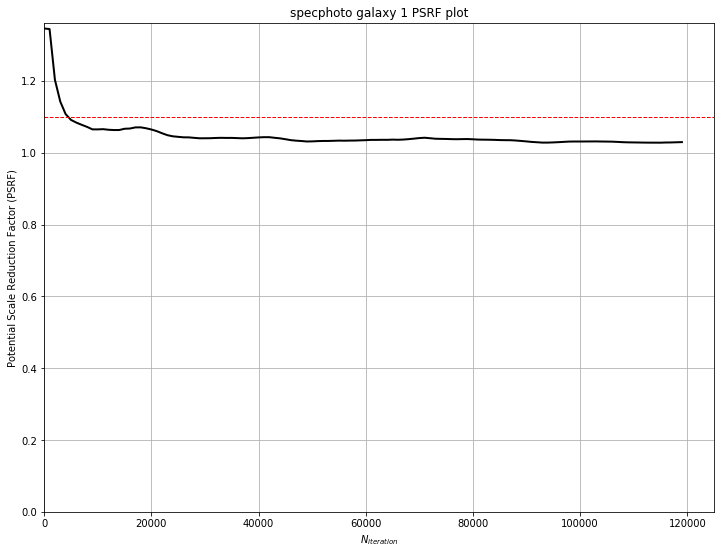

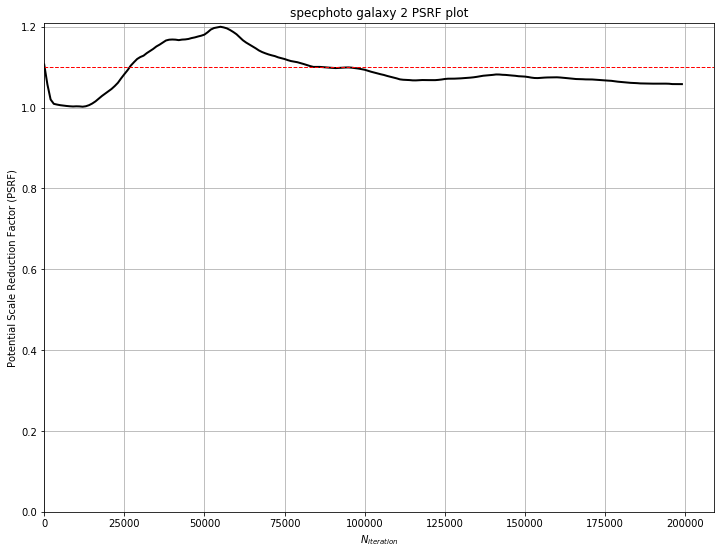

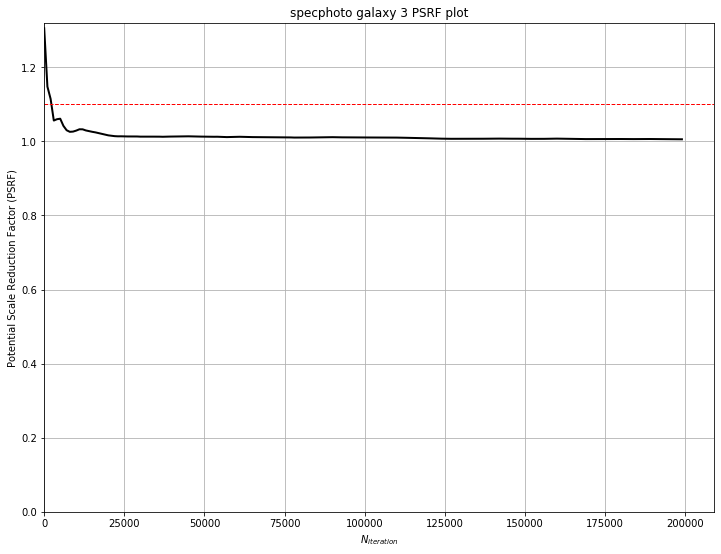

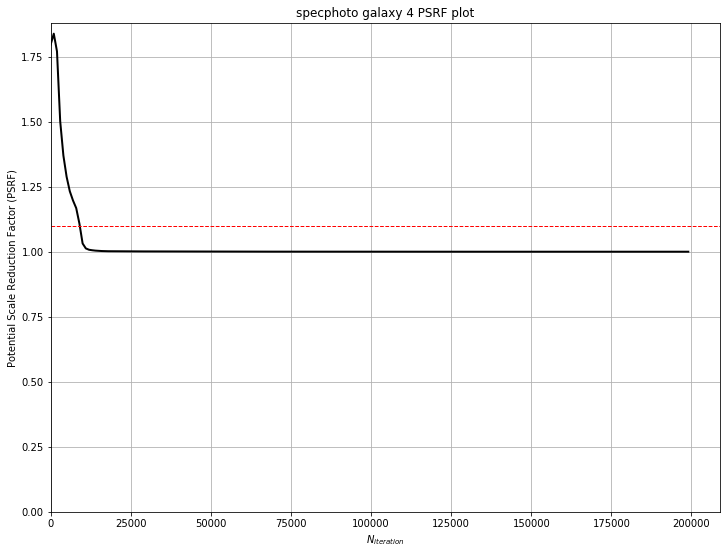

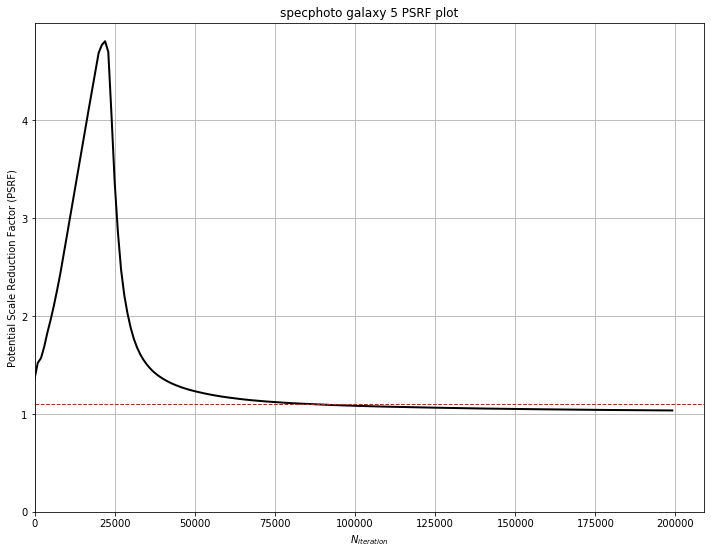

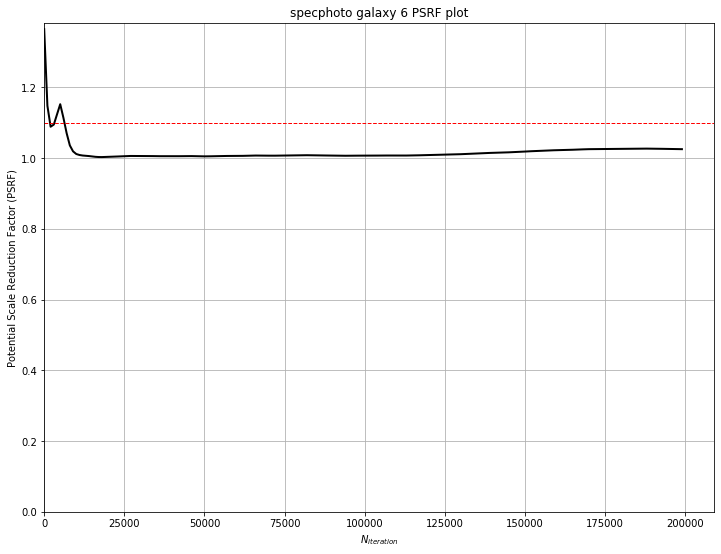

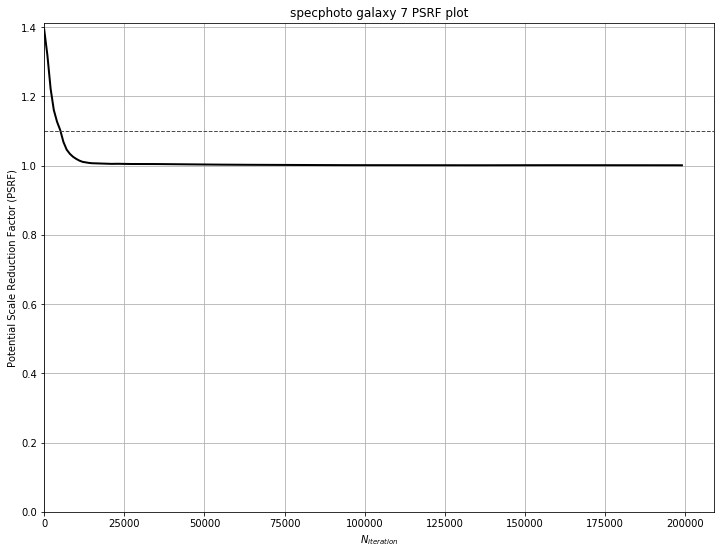

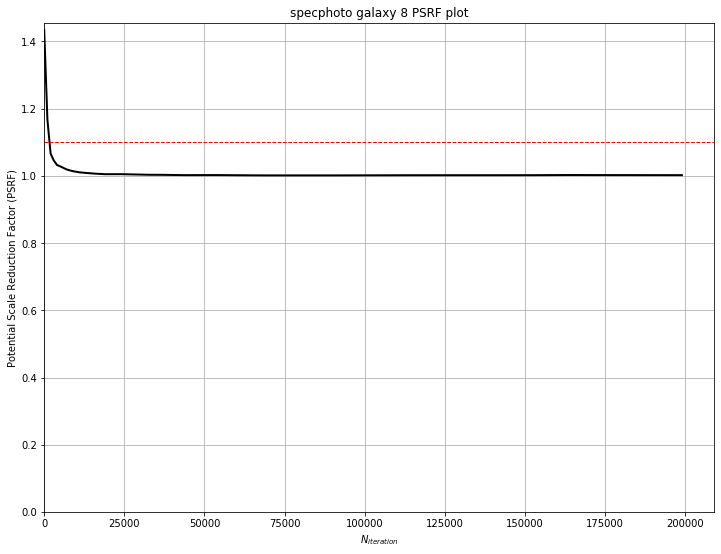

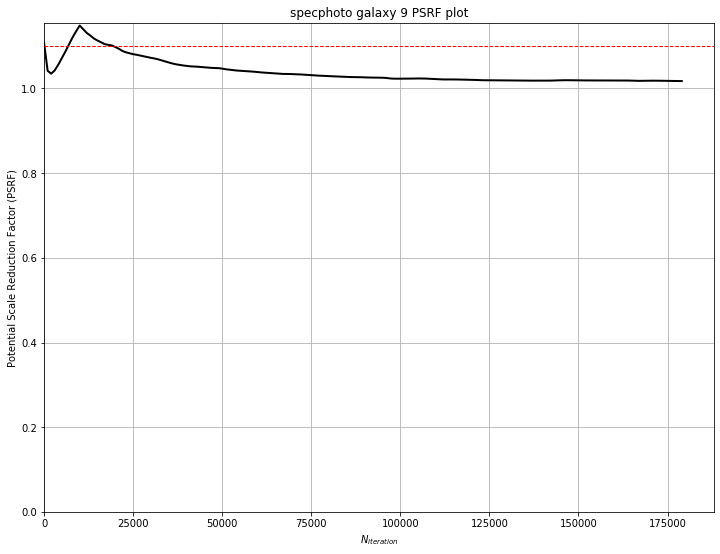

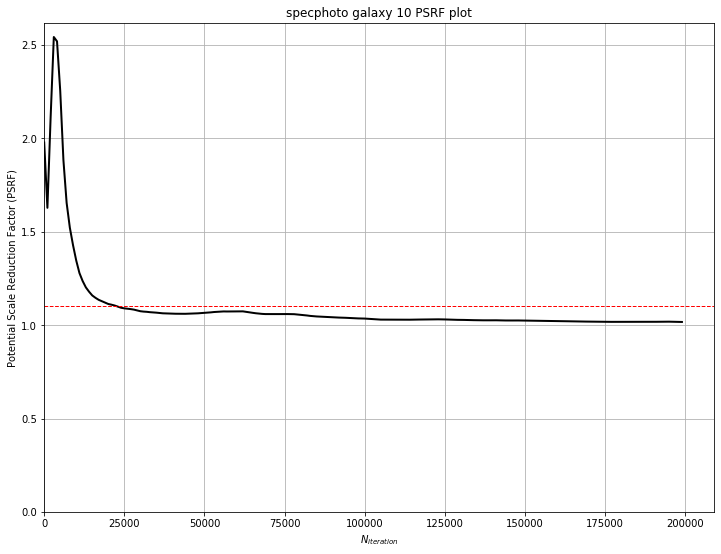

In [27]:
Adptv.PSRF_plot('specphoto')

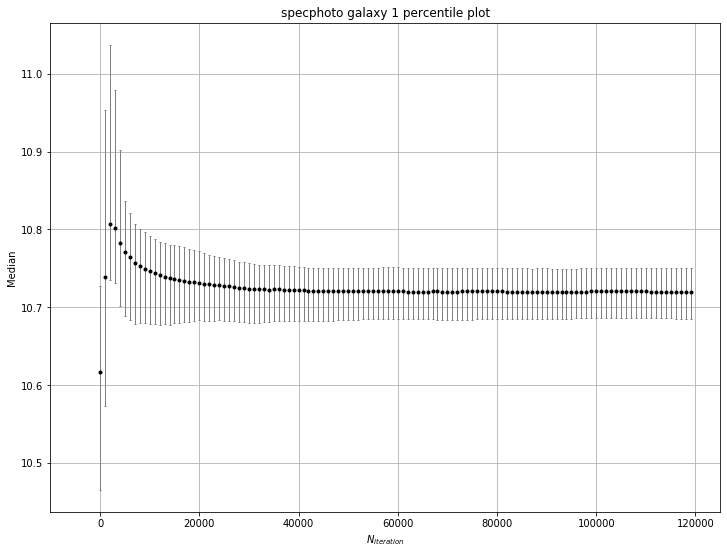

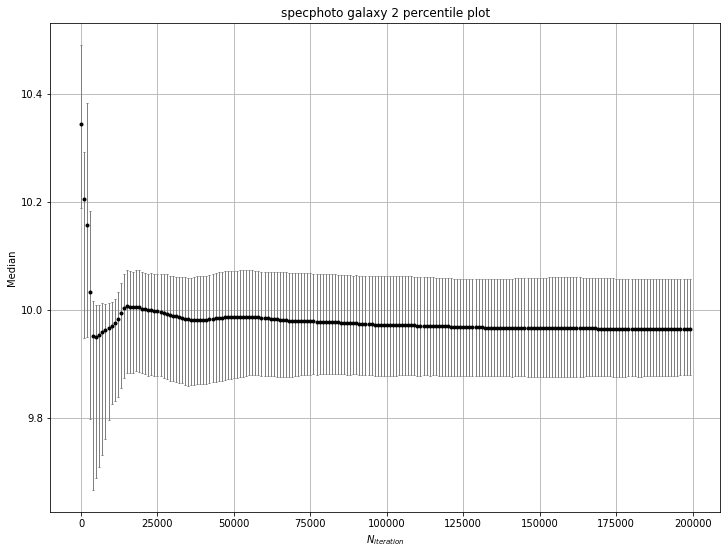

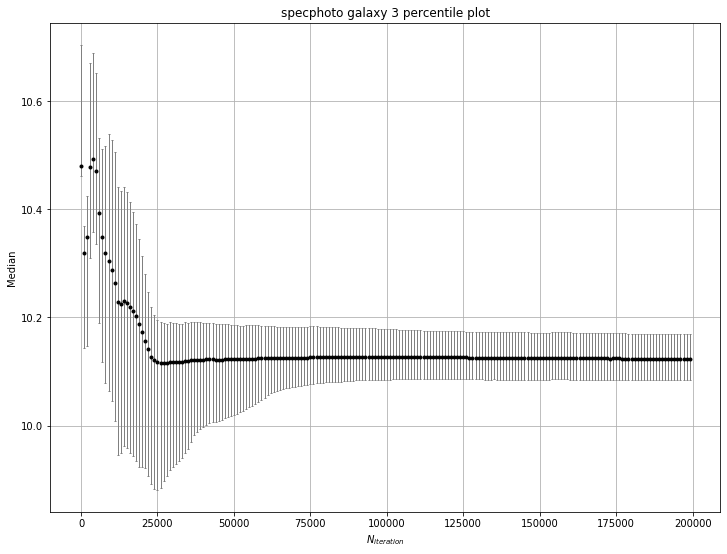

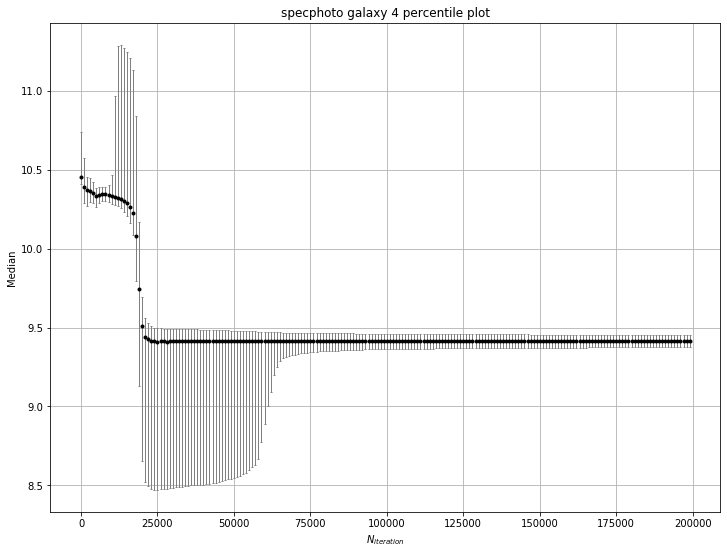

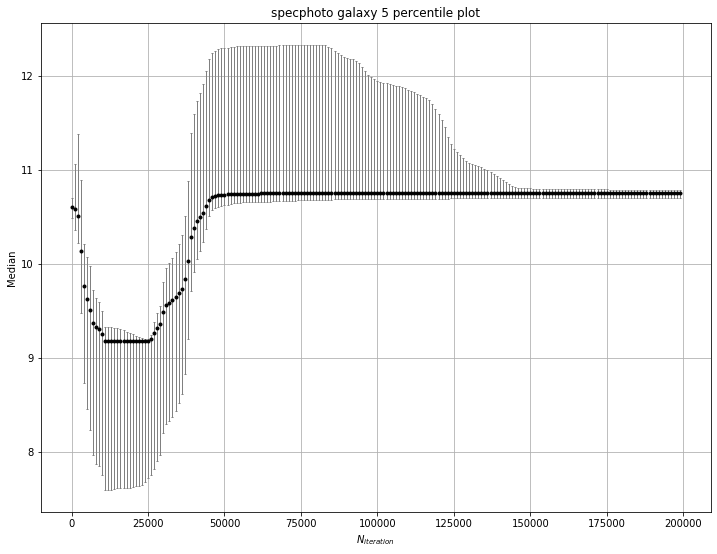

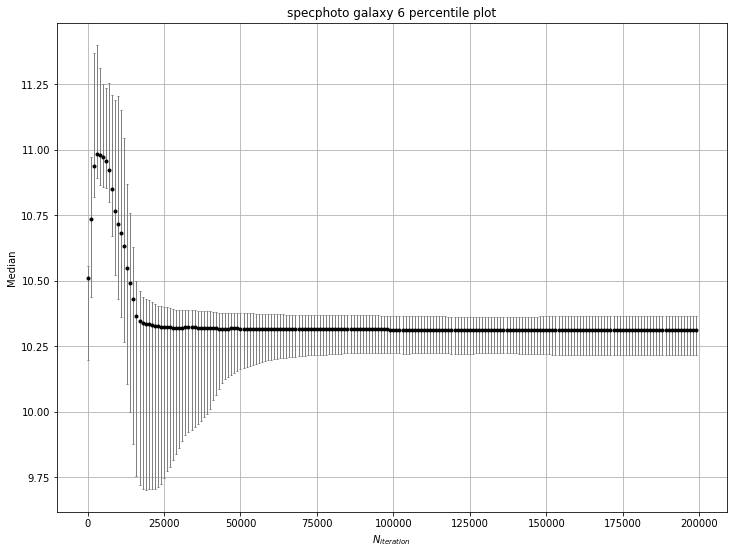

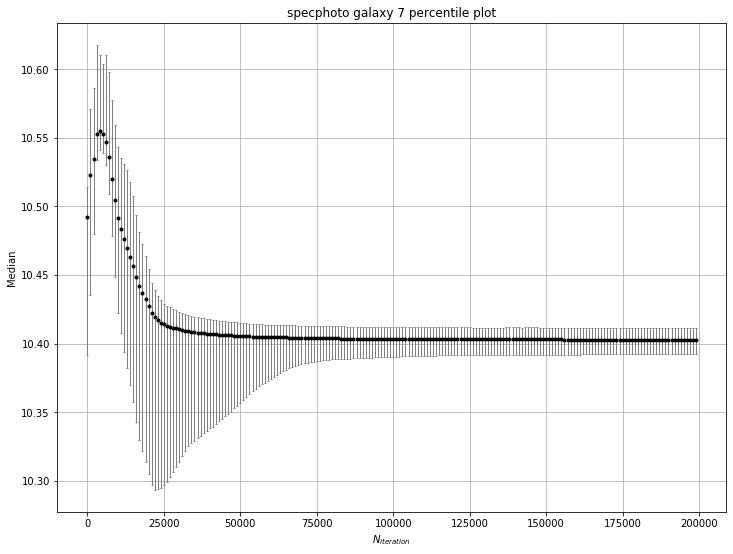

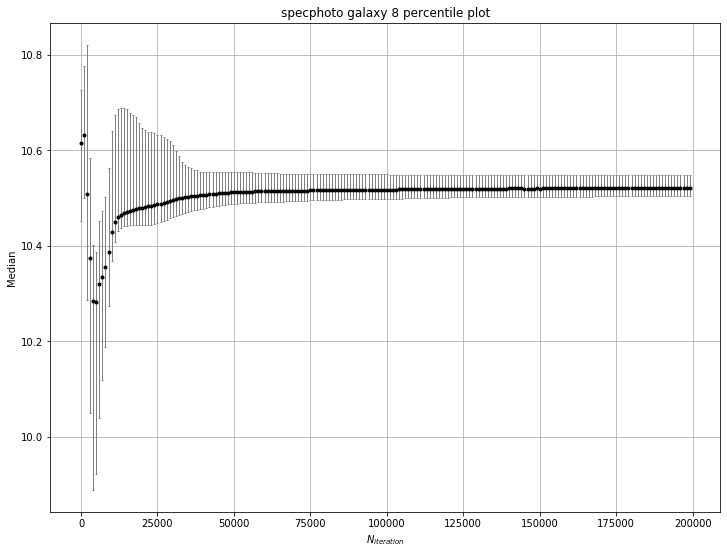

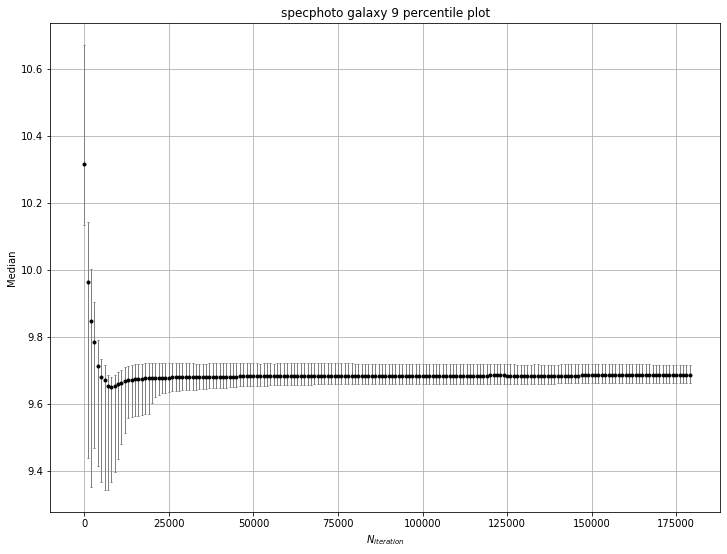

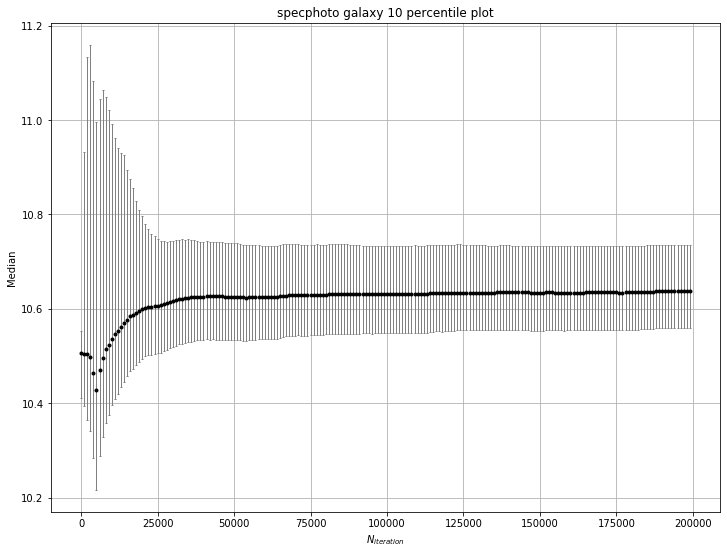

In [28]:
Adptv.perc_plot('specphoto')

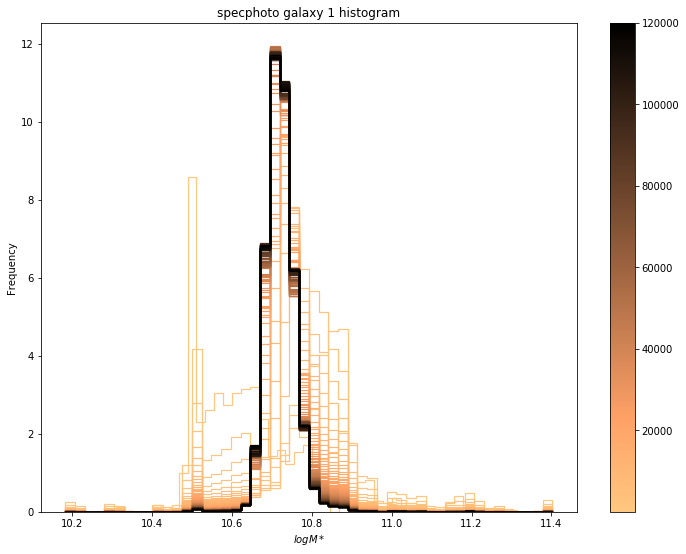

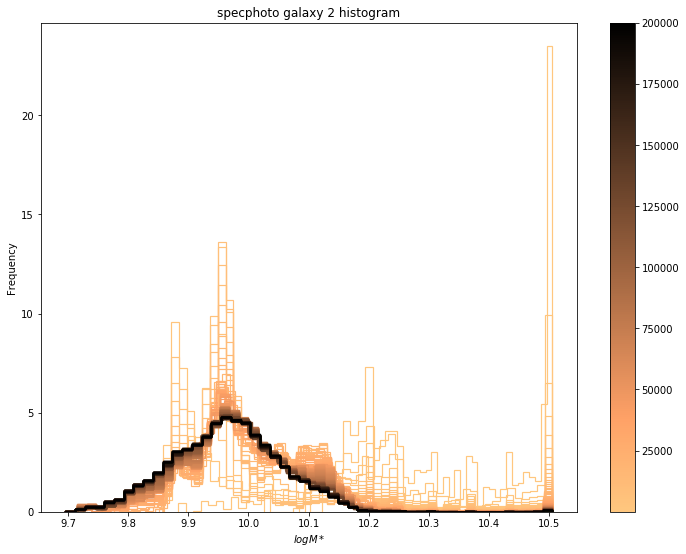

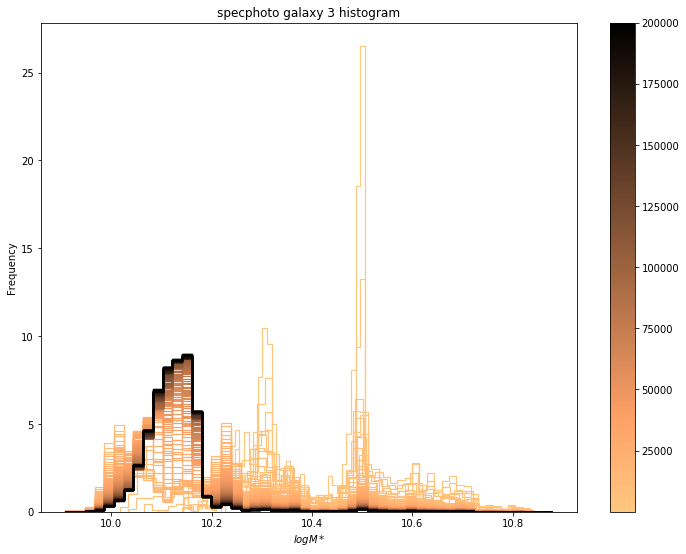

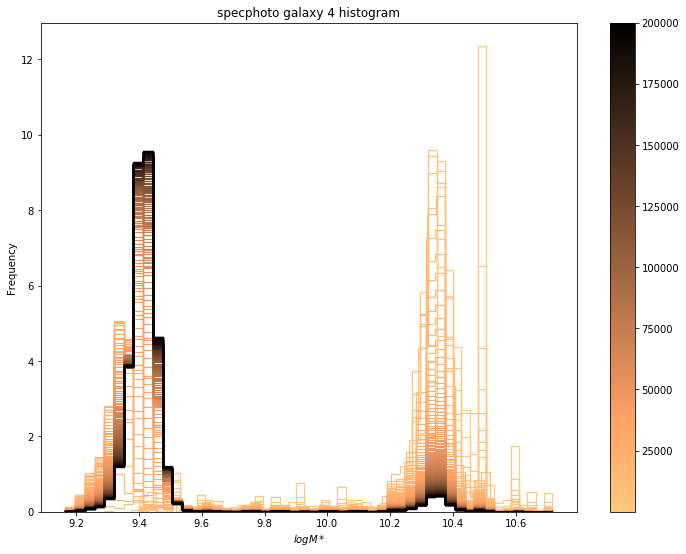

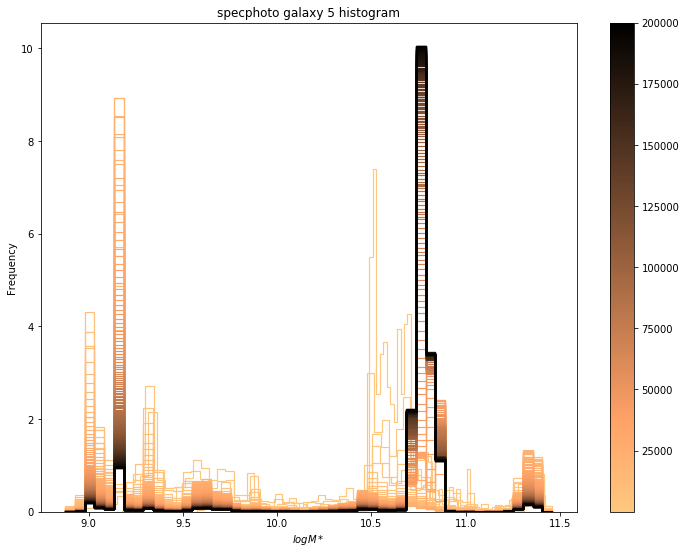

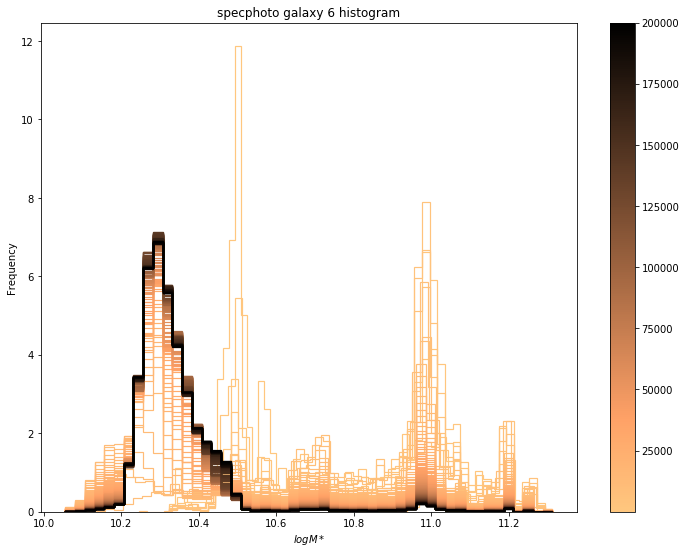

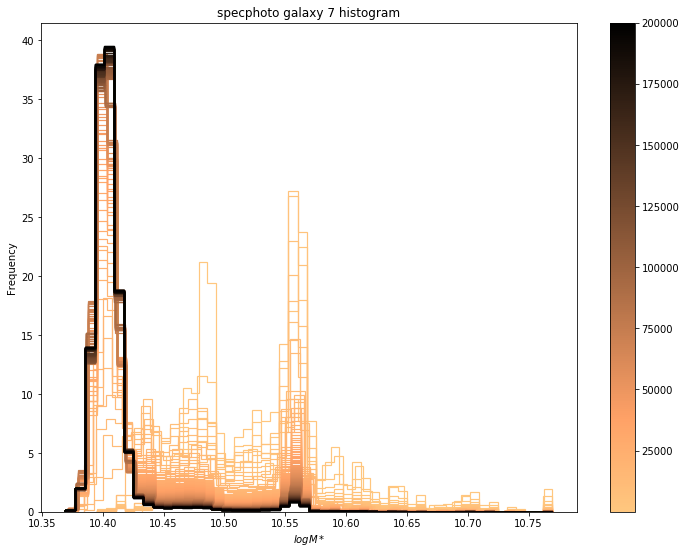

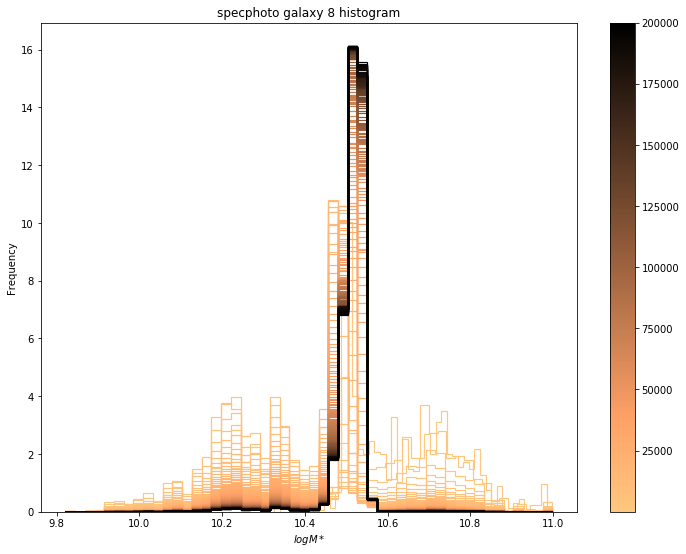

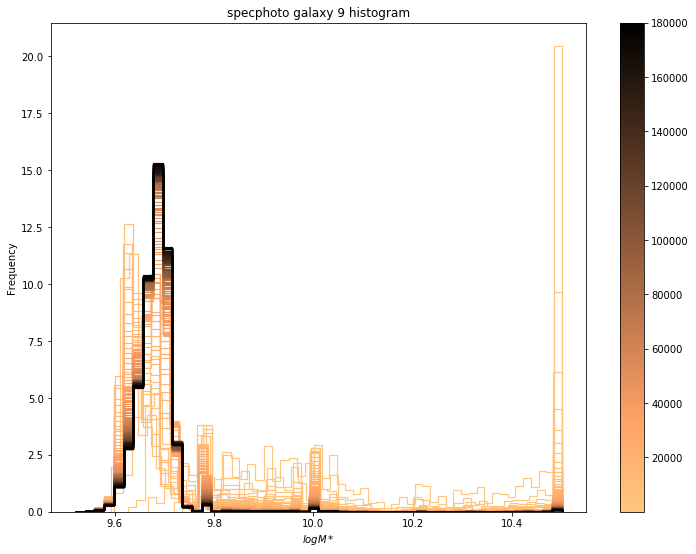

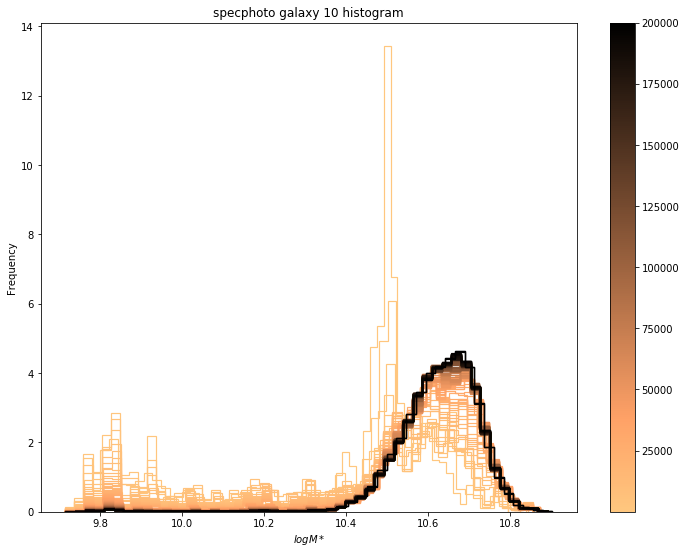

In [23]:
Adptv.hist_plot('specphoto')